In [4]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import csv
from tqdm import tqdm
import json
from scipy.ndimage import label
from glob import glob
import pandas as pd
import openslide
from PIL import Image, ImageDraw

In [2]:
parent_folder      = "/gpfs/scratch/leh06/hovernet/01_results/tcga_luad_240323/004_Van_NYUape_pannuke_type/224px_tcga_luad_0.504umpx/"
patch_size    = 224                   # patch width/height in pixels
density_thr   = 0.0001                # cells/pixel
epithelial_id = 1                     # label for epithelial cells
connective_thresh = 4
out_folder  = "/gpfs/scratch/leh06/NivoPembro_Results/Revisions_250415/tumor_masks/"
os.makedirs(out_folder, exist_ok=True)

# Generate tumor masks based on epithelial cell density

For each slide, it will take all tile-level json outputs from Hover-Net, compute the epithelial density in each, assign it a label 'tumor', and filter out isolated 'tumor tiles' to generate a tumor mask.

In [ ]:
for slide_dir in tqdm(sorted(os.listdir(parent_folder))):
    slide_id = slide_dir[:23]
    json_dir = os.path.join(parent_folder, slide_dir, "json")
    if not os.path.isdir(json_dir):
        continue

    # 1) parse each patch JSON and compute epithelial density
    densities = {}
    for fname in os.listdir(json_dir):
        if not fname.endswith(".json"):
            continue
        x_str, y_str = fname[:-5].split("_")
        x, y = int(x_str), int(y_str)
        try:
            data = json.load(open(os.path.join(json_dir, fname)))
            epithelial_centroids = [
                cell["centroid"]
                for cell in data.get("nuc", {}).values()
                if cell.get("type") == epithelial_id
            ]
            densities[(x, y)] = len(epithelial_centroids) / (patch_size * patch_size)
        except:
            print(f"Failed opening json {fname} for slide {slide_id}")

    if not densities:
        continue

    # 2) build the binary patch mask
    xs, ys = zip(*densities.keys())
    nx, ny = max(xs) + 1, max(ys) + 1
    mask = np.zeros((ny, nx), dtype=np.uint8)
    for (i, j), d in densities.items():
        mask[j, i] = 1 if d >= density_thr else 0

    # 3) connected component analysis to filter isolated tiles
    structure = np.ones((3, 3), dtype=np.uint8)  # 8-connectivity
    labeled_mask, num_components = label(mask, structure=structure)

    # 4) Keep only tiles in components with at least 2 tiles (change if needed)
    final_mask = np.zeros_like(mask)
    for comp_id in range(1, num_components + 1):
        comp_coords = np.argwhere(labeled_mask == comp_id)
        if len(comp_coords) >= connective_thresh:  # Minimum size threshold for connected regions
            for y, x in comp_coords:
                final_mask[y, x] = 1

    # 5a) save final mask
    np.save(os.path.join(out_folder, f"{slide_id}_patch_mask.npy"), final_mask)

    # 5b) save filtered tumor-tile list
    with open(os.path.join(out_folder, f"{slide_id}_tumor_tiles.csv"), "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["x_idx", "y_idx"])
        for y, x in np.argwhere(final_mask == 1):
            w.writerow([x, y])

# Visualizing the tumor mask

In [6]:
def add_tumor_tile_overlay(draw, slide_id, slide, downsample_factor, patch_mask_dir, tile_size_20x, color):
    """
    Overlay tumor tile rectangles using 20x tile coordinates, downsampled to target magnification.
    """
    mask_path = os.path.join(patch_mask_dir, f"{slide_id}_patch_mask.npy")
    if not os.path.exists(mask_path):
        print(f"No tumor mask found for {slide_id}")
        return

    mask = np.load(mask_path)  # shape (ny, nx)

    # Convert tile size at 20x to pixel size at base resolution
    base_mpp = float(slide.properties["openslide.mpp-x"])  # microns/pixel
    tile_size_microns = tile_size_20x * 0.504  # Because 20x → 0.504 µm/pixel
    tile_size_base_px = int(tile_size_microns / base_mpp)

    for j in range(mask.shape[0]):
        for i in range(mask.shape[1]):
            if mask[j, i] == 1:
                # Top-left corner at base resolution
                x_base = i * tile_size_base_px
                y_base = j * tile_size_base_px

                # Downsample to display resolution
                x_ds = int(x_base / downsample_factor)
                y_ds = int(y_base / downsample_factor)
                tile_ds = int(tile_size_base_px / downsample_factor)

                draw.rectangle(
                    [x_ds, y_ds, x_ds + tile_ds, y_ds + tile_ds],
                    outline=(0, 255, 255, 255), # solid cyan
                    width=3
                )
def convert_mags_from_20x(coords_20x, target_pixel_size):
    """
    Converts coordinates from 20x magnification to a desired magnification.

    Args:
        coords_20x (float): Coordinate at 20x magnification.
        target_pixel_size (float): Desired target pixel size level.

    Returns:
        int: Converted coordinate for the specified magnification.
    """
    final_coords = coords_20x * (447 / 224 * 0.2525) / target_pixel_size
    return int(final_coords)


def load_cluster_data(cluster_csv):
    """
    Loads cluster assignments from the main CSV file and its test/validation splits.

    Args:
        cluster_csv (str): Path to the main cluster assignment CSV.

    Returns:
        pd.DataFrame: Combined DataFrame of cluster assignments.
    """
    cluster_df = pd.read_csv(cluster_csv)
    cluster_df['slides'] = cluster_df['slides'].astype(str)

    for suffix in ["_test.csv", "_valid.csv"]:
        additional_csv = cluster_csv.replace(".csv", suffix)
        if os.path.exists(additional_csv):
            additional_df = pd.read_csv(additional_csv)
            cluster_df = pd.concat([cluster_df, additional_df], axis=0, ignore_index=True)

    return cluster_df


def compute_tile_composition(cluster_df, leiden_col, hpc):
    """
    Computes the composition of tiles for each slide and ranks slides by HPC of interest.

    Args:
        cluster_df (pd.DataFrame): Cluster assignments DataFrame.
        leiden_col (str): Column name containing cluster assignments.
        hpc (int): HPC of interest.

    Returns:
        pd.DataFrame: Ranked slides based on HPC composition.
        pd.DataFrame: Filtered DataFrame of tiles for the HPC of interest.
    """
    tile_counts = cluster_df.groupby(['slides', leiden_col]).size().reset_index(name='tile_count')
    total_tiles = cluster_df.groupby('slides').size().reset_index(name='total_count')
    tile_composition_vectors = pd.merge(tile_counts, total_tiles, on='slides')
    tile_composition_vectors['hpc_perc'] = (tile_composition_vectors['tile_count'] / tile_composition_vectors['total_count']) * 100

    tile_composition_hpc = tile_composition_vectors[tile_composition_vectors[leiden_col] == hpc]
    tile_composition_hpc = tile_composition_hpc.sort_values(by='hpc_perc', ascending=False)

    hpc_df = cluster_df[cluster_df[leiden_col] == hpc]
    return tile_composition_hpc, hpc_df


def add_tile_overlay(draw, hpc_slide_df, cell_summary_df, slide, downsample_factor, fill_color_hpc, window_size_40x):
    """
    Adds rectangular overlays for tiles belonging to the specified HPC.

    Args:
        draw (PIL.ImageDraw.ImageDraw): Drawing object for overlay.
        hpc_slide_df (pd.DataFrame): DataFrame of HPC tiles for the slide.
        cell_summary_df (pd.DataFrame): Cell summary DataFrame.
        slide (openslide.OpenSlide): OpenSlide object for the slide.
        downsample_factor (float): Downsampling factor from base magnification.
        fill_color_hpc (tuple): RGBA color for HPC tiles.
        window_size_40x (int): Window size at 40x magnification.
    """
    for _, row in hpc_slide_df.iterrows():
        centroid_x = cell_summary_df.loc[cell_summary_df.CellID == row.tiles, 'Centroid_x'].values[0]
        centroid_y = cell_summary_df.loc[cell_summary_df.CellID == row.tiles, 'Centroid_y'].values[0]
        
        x = convert_mags_from_20x(centroid_x, float(slide.properties["openslide.mpp-x"]))
        y = convert_mags_from_20x(centroid_y, float(slide.properties["openslide.mpp-x"]))
        
        scaled_x = int(round((x - window_size_40x / 2) / downsample_factor))
        scaled_y = int(round((y - window_size_40x / 2) / downsample_factor))
        scaled_window_size = int(round(window_size_40x / downsample_factor))

        draw.rectangle([scaled_x, scaled_y, scaled_x + scaled_window_size, scaled_y + scaled_window_size], fill=fill_color_hpc,
                      outline=(186, 142, 35), width = 2)


def add_centroid_overlay(draw, cell_summary_df, cell_type, slide, downsample_factor, dot_radius, fill_color):
    """
    Adds circular overlays for cell centroids of a specific type.

    Args:
        draw (PIL.ImageDraw.ImageDraw): Drawing object for overlay.
        cell_summary_df (pd.DataFrame): Cell summary DataFrame.
        cell_type (int): Cell type identifier.
        slide (openslide.OpenSlide): OpenSlide object for the slide.
        downsample_factor (float): Downsampling factor from base magnification.
        dot_radius (int): Radius of the circle for centroids.
        fill_color (tuple): RGBA color for the centroids.
    """
    cell_summary_filtered = cell_summary_df[cell_summary_df["CellType"] == cell_type]
    for _, row in cell_summary_filtered.iterrows():
        cx = convert_mags_from_20x(row.Centroid_x, float(slide.properties["openslide.mpp-x"]))
        cy = convert_mags_from_20x(row.Centroid_y, float(slide.properties["openslide.mpp-x"]))
        
        scaled_cx = int(round(cx / downsample_factor))
        scaled_cy = int(round(cy / downsample_factor))
        
        draw.ellipse(
            [scaled_cx - dot_radius, scaled_cy - dot_radius, scaled_cx + dot_radius, scaled_cy + dot_radius],
            fill=fill_color
        )

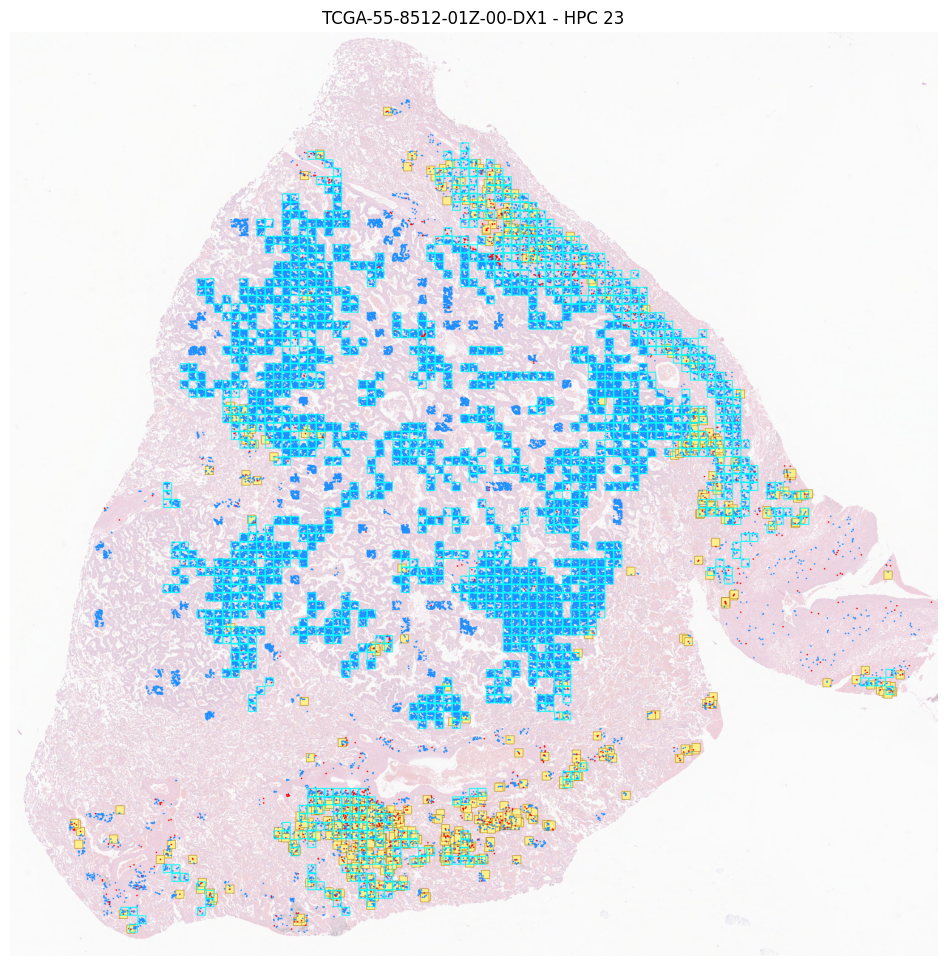

In [8]:
# Load cluster data
hpc = 23
cluster_csv = "/gpfs/data/tsirigoslab/home/leh06/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/tcga_luad_cell_224px_20x/h224_w224_n3_zdim128/survival/adatas/tcga_luad_cell_224px_20x_he_complete_lungsubtype_survival_leiden_1p0__fold1.csv"
wsi_paths = "/gpfs/data/abl/ABL-public-TCGA-Pathology/diagnostic_lung/svs_All/svs_LUAD/"
hover_net_path = "/gpfs/scratch/leh06/hovernet/01_results/tcga_luad_240323/004_Van_NYUape_pannuke_type/224px_tcga_luad_0.504umpx"
window_size = 224
tile_mask_dir = "/gpfs/scratch/leh06/NivoPembro_Results/Revisions_250415/tumor_masks/"

cluster_df = load_cluster_data(cluster_csv)
leiden_col = cluster_df.columns[cluster_df.columns.str.contains("leiden")].values[0]

# Compute tile composition
tile_composition_hpc, hpc_df = compute_tile_composition(cluster_df, leiden_col, hpc)
# Select the top slides by HPC percentage

target_magnification = 2.5
dot_radius = 2
fill_color_hpc =  (255, 238, 140) # Color for HPC tiles
fill_color_tumor = (30,144,255)  # Blue for tumor cells
fill_color_immune = (255,0,0)  # Red for immune cells

# Gather .svs files from the provided paths
svs_paths = glob(os.path.join(wsi_paths, "*", "*.svs"))

# Process each top slide
slide_id = "TCGA-55-8512-01Z-00-DX1"
slide_hpc_df = hpc_df[hpc_df['slides'] == slide_id]

# Find matching .svs file
slide_path = [i for i in svs_paths if os.path.basename(i).split(".")[0] == str(slide_id)][0]
if slide_path is None:
    print(f"No .svs file found for slide {slide_id}")

# Open slide and retrieve properties
slide = openslide.OpenSlide(slide_path)
base_magnification = float(slide.properties[openslide.PROPERTY_NAME_OBJECTIVE_POWER])
downsample_factor =  base_magnification / target_magnification

# Get WSI dimensions at the base level
wsi_width, wsi_height = slide.dimensions

# Calculate dimensions for downsampled WSI
new_width = int(wsi_width / downsample_factor)
new_height = int(wsi_height / downsample_factor)

# Read region from the WSI at a lower magnification
downsampled_wsi = slide.get_thumbnail((new_width, new_height))

# Prepare a blank image for overlay
overlay = Image.new("RGBA", downsampled_wsi.size, (0, 0, 0, 0))
draw = ImageDraw.Draw(overlay, "RGBA")

# Load HoverNet cell summary if applicable
if "TCGA" in str(slide_id):
    cell_summary_path = glob(os.path.join(hover_net_path, str(slide_id) + ".*_files", f"cell_summary_{str(window_size)}px", "*.csv"))[0]
else:
    cell_summary_path = glob(os.path.join(hover_net_path, str(slide_id) + "*_files", f"cell_summary_{str(window_size)}px", "*.csv"))[0]

cell_summary_df = pd.read_csv(cell_summary_path)

# Convert 20x window size of 224 to 40x
window_size_40x = convert_mags_from_20x(window_size, float(slide.properties["openslide.mpp-x"]))
    
# Add HPC tile overlays
add_tile_overlay(draw, slide_hpc_df, cell_summary_df, slide, downsample_factor, fill_color_hpc, window_size_40x)

# Add tumor centroid overlays 
add_centroid_overlay(draw, cell_summary_df, cell_type=1, slide=slide, downsample_factor=downsample_factor, dot_radius=dot_radius, fill_color=fill_color_tumor)

# Add immune centroid overlays if immune_flag is set
add_centroid_overlay(draw, cell_summary_df, cell_type=2, slide=slide, downsample_factor=downsample_factor, dot_radius=dot_radius, fill_color=fill_color_immune)

add_tumor_tile_overlay(draw, slide_id, slide, downsample_factor,
                               tile_mask_dir, tile_size_20x=window_size,
                               color=(0, 0, 255, 150))
# Blend the overlay with the downsampled more transparent WSI
downsampled_wsi = downsampled_wsi.convert("RGBA")
white_background = Image.new("RGBA", downsampled_wsi.size, (255, 255, 255, 255))
softened_downsampled_wsi = Image.blend(white_background, downsampled_wsi, alpha=0.3)
downsampled_wsi_overlay= Image.alpha_composite(softened_downsampled_wsi, overlay)
plt.figure(figsize=(12, 12))
plt.imshow(downsampled_wsi_overlay)
plt.axis("off")
plt.title(f"{slide_id} - HPC {hpc}")
plt.show()

# Colocalization analysis

In [10]:
def compute_overall_immune_proximity_across_slides(
    all_slide_ids,
    cluster_df,
    tumor_mask_dir,
    hovernet_csv_dir,
    cluster_column,
    patch_size=224,
    immune_type=2,
    radius_microns=100,
    microns_per_pixel=0.504
):
    from collections import defaultdict
    all_immune_cells = []
    tumor_coords_global = []

    hpc_tile_dict_tumor = defaultdict(list)
    hpc_tile_dict_all = defaultdict(list)
    hpc_tile_counts = defaultdict(int)
    hpc_tumor_tile_counts = defaultdict(int)

    for slide_id in tqdm(all_slide_ids):
        slide_cluster_df = cluster_df[cluster_df['slides'] == slide_id].copy()
        if slide_cluster_df.empty:
            continue

        slide_cluster_df['x'] = slide_cluster_df['tiles'].apply(lambda x: int(x.split('_')[0]))
        slide_cluster_df['y'] = slide_cluster_df['tiles'].apply(lambda x: int(x.split('_')[1].replace(".jpeg", "")))

        tumor_mask_path = os.path.join(tumor_mask_dir, f"{slide_id}_patch_mask.npy")
        if not os.path.exists(tumor_mask_path):
            continue
        tumor_mask = np.load(tumor_mask_path)
        ny, nx = tumor_mask.shape

        def tumor_flag(row):
            x, y = row['x'], row['y']
            return int(tumor_mask[y, x]) if 0 <= y < ny and 0 <= x < nx else 0

        slide_cluster_df['is_tumor'] = slide_cluster_df.apply(tumor_flag, axis=1)

        # Track total and tumor tile counts
        for _, row in slide_cluster_df.iterrows():
            hpc = row[cluster_column]
            hpc_tile_counts[hpc] += 1
            if row['is_tumor'] == 1:
                hpc_tumor_tile_counts[hpc] += 1

        tumor_tiles = slide_cluster_df[slide_cluster_df['is_tumor'] == 1].copy()
        all_tiles = slide_cluster_df.copy()

        if not tumor_tiles.empty:
            tumor_tiles['x_microns'] = tumor_tiles['x'] * patch_size * microns_per_pixel
            tumor_tiles['y_microns'] = tumor_tiles['y'] * patch_size * microns_per_pixel
            for hpc in tumor_tiles[cluster_column].unique():
                coords = tumor_tiles[tumor_tiles[cluster_column] == hpc][['x_microns', 'y_microns']].values
                tumor_coords_global.extend(tumor_tiles[['x_microns', 'y_microns']].values)
                hpc_tile_dict_tumor[hpc].extend(coords)

        # Record all tiles for immune adjacency (not just tumor)
        all_tiles['x_microns'] = all_tiles['x'] * patch_size * microns_per_pixel
        all_tiles['y_microns'] = all_tiles['y'] * patch_size * microns_per_pixel
        for hpc in all_tiles[cluster_column].unique():
            coords = all_tiles[all_tiles[cluster_column] == hpc][['x_microns', 'y_microns']].values
            hpc_tile_dict_all[hpc].extend(coords)

        # Load HoverNet immune cells
        try:
            if "TCGA" in slide_id:
                cell_summary_path = glob(os.path.join(hovernet_csv_dir, f"{slide_id}.*_files", f"cell_summary_{patch_size}px", "*.csv"))[0]
            else:
                cell_summary_path = glob(os.path.join(hovernet_csv_dir, f"{slide_id}*_files", f"cell_summary_{patch_size}px", "*.csv"))[0]
        except IndexError:
            continue
        if not os.path.exists(cell_summary_path):
            continue

        cell_df = pd.read_csv(cell_summary_path)
        immune_df = cell_df[cell_df["CellType"] == immune_type]
        immune_coords = immune_df[["Centroid_x", "Centroid_y"]].values * microns_per_pixel
        all_immune_cells.extend(immune_coords)

    if not all_immune_cells or not hpc_tile_dict_tumor:
        return pd.DataFrame([{
            'cn_hpc': -1,
            'P(immune near cn-HPC | in tumor region)': 0,
            'P(immune near cn-HPC)': 0,
            'Proportion of cn-HPC tiles in tumor': 0,
            'Mean distance to tumor (µm)': mean_dist_to_tumor 
        }])

    all_immune_cells = np.array(all_immune_cells)
    tumor_coords_global = np.array(tumor_coords_global)
    tumor_tree = cKDTree(tumor_coords_global)
    results = []

    for hpc_id in tqdm(hpc_tile_dict_all.keys()):
        coords_all = np.array(hpc_tile_dict_all[hpc_id])
        coords_tumor = np.array(hpc_tile_dict_tumor.get(hpc_id, []))

        if len(coords_all) > 0:
            # Immune proximity (global)
            tree_all = cKDTree(coords_all)
            adjacent_all = tree_all.query_ball_point(all_immune_cells, r=radius_microns)
            prop_adjacent_all = sum(len(a) > 0 for a in adjacent_all) / len(all_immune_cells)

            # Mean Euclidean distance (in microns) to nearest tumor tile
            dists_to_tumor, _ = tumor_tree.query(coords_all, k=1)
            mean_dist_to_tumor = np.mean(dists_to_tumor)
        else:
            prop_adjacent_all = 0
            prop_cnhpc_near_tumor = 0
            mean_dist_to_tumor = np.nan

        # Immune proximity (tumor only)
        if len(coords_tumor) > 0:
            tree_tumor = cKDTree(coords_tumor)
            adjacent_tumor = tree_tumor.query_ball_point(all_immune_cells, r=radius_microns)
            prop_adjacent_tumor = sum(len(a) > 0 for a in adjacent_tumor) / len(all_immune_cells)
        else:
            prop_adjacent_tumor = 0

        # Tumor localization ratio
        total = hpc_tile_counts[hpc_id]
        tumor = hpc_tumor_tile_counts[hpc_id]
        tumor_ratio = tumor / total if total > 0 else 0

        results.append({
            'cn_hpc': hpc_id,
            'P(immune near cn-HPC | in tumor region)': prop_adjacent_tumor,
            'P(immune near cn-HPC)': prop_adjacent_all,
            'Proportion of cn-HPC tiles in tumor': tumor_ratio,
            'Mean distance to tumor (µm)': mean_dist_to_tumor 
        })

    return pd.DataFrame(results)

In [ ]:
all_slide_ids = cluster_df['slides'].unique()  # all slides in the cluster data
cluster_column = leiden_col
patch_size = window_size
immune_type = 2  # HoverNet immune cell type

results_df = compute_overall_immune_proximity_across_slides(
    all_slide_ids=all_slide_ids,
    cluster_df=cluster_df,
    tumor_mask_dir=tile_mask_dir,
    hovernet_csv_dir=hover_net_path,
    cluster_column=cluster_column,
    patch_size=patch_size,
    immune_type=immune_type,
    radius_microns=100
)

results_df.to_csv('/gpfs/scratch/leh06/NivoPembro_Results/Revisions_250415/cnhpc_immune_proximity_results.csv', index = False)